In [13]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# 1. LOAD DATA
# ============================================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv('men_2026_matchups_training.csv')

# Filter for Sweet 16 and Elite Eight
rounds_of_interest = ['Sweet 16', 'Elite Eight']
df_filtered = df[df['round'].isin(rounds_of_interest)].copy()

print(f"Original Dataset Shape: {df.shape}")
print(f"Filtered Dataset Shape: {df_filtered.shape}")
print(f"\nRound Distribution:")
print(df_filtered['round'].value_counts())
print(f"\nTarget Variable Distribution:")
print(df_filtered['win'].value_counts())
print(f"Win Rate: {df_filtered['win'].mean():.2%}")

# ============================================
# 2. PREPARE FEATURES (EXCLUDING SEEDS)
# ============================================
print("\n" + "="*60)
print("PREPARING FEATURES")
print("="*60)

exclude_cols = ['Unnamed: 0', 'game_id', 'year', 'region', 'round',
                'high_bracket_team', 'low_bracket_team', 'win',
                'high_bracket_seed', 'low_bracket_seed']
feature_cols = [col for col in df_filtered.columns if col not in exclude_cols]

X = df_filtered[feature_cols].copy()
y = df_filtered['win'].copy()

# Clean data
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

print(f"Feature Matrix Shape: {X.shape}")
print(f"Number of Features: {X.shape[1]}")

# ============================================
# 3. TRAIN/TEST SPLIT
# ============================================
print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training win rate: {y_train.mean():.2%}")
print(f"Test win rate: {y_test.mean():.2%}")

LOADING DATA
Original Dataset Shape: (1254, 118)
Filtered Dataset Shape: (238, 118)

Round Distribution:
round
Sweet 16       158
Elite Eight     80
Name: count, dtype: int64

Target Variable Distribution:
win
1    119
0    119
Name: count, dtype: int64
Win Rate: 50.00%

PREPARING FEATURES
Feature Matrix Shape: (238, 108)
Number of Features: 108

TRAIN/TEST SPLIT
Training set size: 190
Test set size: 48
Training win rate: 50.00%
Test win rate: 50.00%



EXPLORATORY DATA ANALYSIS

--- Top 20 Features Correlated with Winning ---
                       Feature  Correlation
                      5man_bpm     0.390190
                      3man_bpm     0.372838
                           wab     0.358269
                    kenpom_rtg     0.312843
                     5man_dbpm     0.295636
         def_experience_impact     0.272333
                     3man_dbpm     0.269521
                     3man_obpm     0.262458
                     5man_obpm     0.261139
                    torvik_def     0.256264
                    kenpom_def     0.244748
experience_weighted_production     0.238193
    def_four_factors_composite     0.234261
                      efgd_pct     0.231280
                    torvik_rtg     0.228924
                def_3pt_fg_pct     0.217124
              rotation_balance    -0.214587
 def_effective_possession_rate     0.210123
      def_lineup_depth_quality    -0.198303
                       3pd_pct     0.193181


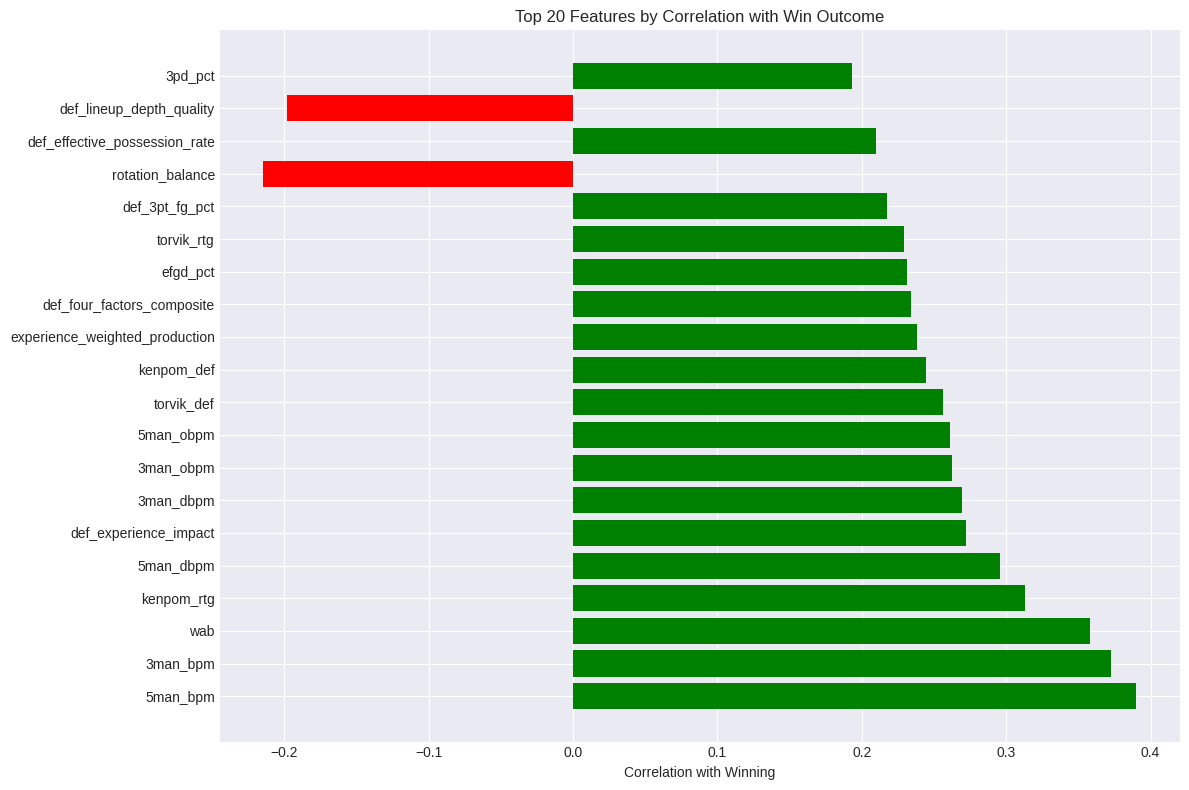

In [14]:
# ============================================
# 4. EXPLORATORY DATA ANALYSIS
# ============================================
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Feature correlations with target (using training data only)
print("\n--- Top 20 Features Correlated with Winning ---")
correlations = pd.DataFrame({
    'Feature': X_train.columns,
    'Correlation': [X_train[col].corr(y_train) for col in X_train.columns]
})
correlations['Abs_Correlation'] = correlations['Correlation'].abs()
top_correlations = correlations.nlargest(20, 'Abs_Correlation')
print(top_correlations[['Feature', 'Correlation']].to_string(index=False))

# Plot 1: Top correlations
plt.figure(figsize=(12, 8))
top_20 = correlations.nlargest(20, 'Abs_Correlation')
colors = ['green' if x > 0 else 'red' for x in top_20['Correlation']]
plt.barh(range(len(top_20)), top_20['Correlation'], color=colors)
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Correlation with Winning')
plt.title('Top 20 Features by Correlation with Win Outcome')
plt.tight_layout()
plt.show()

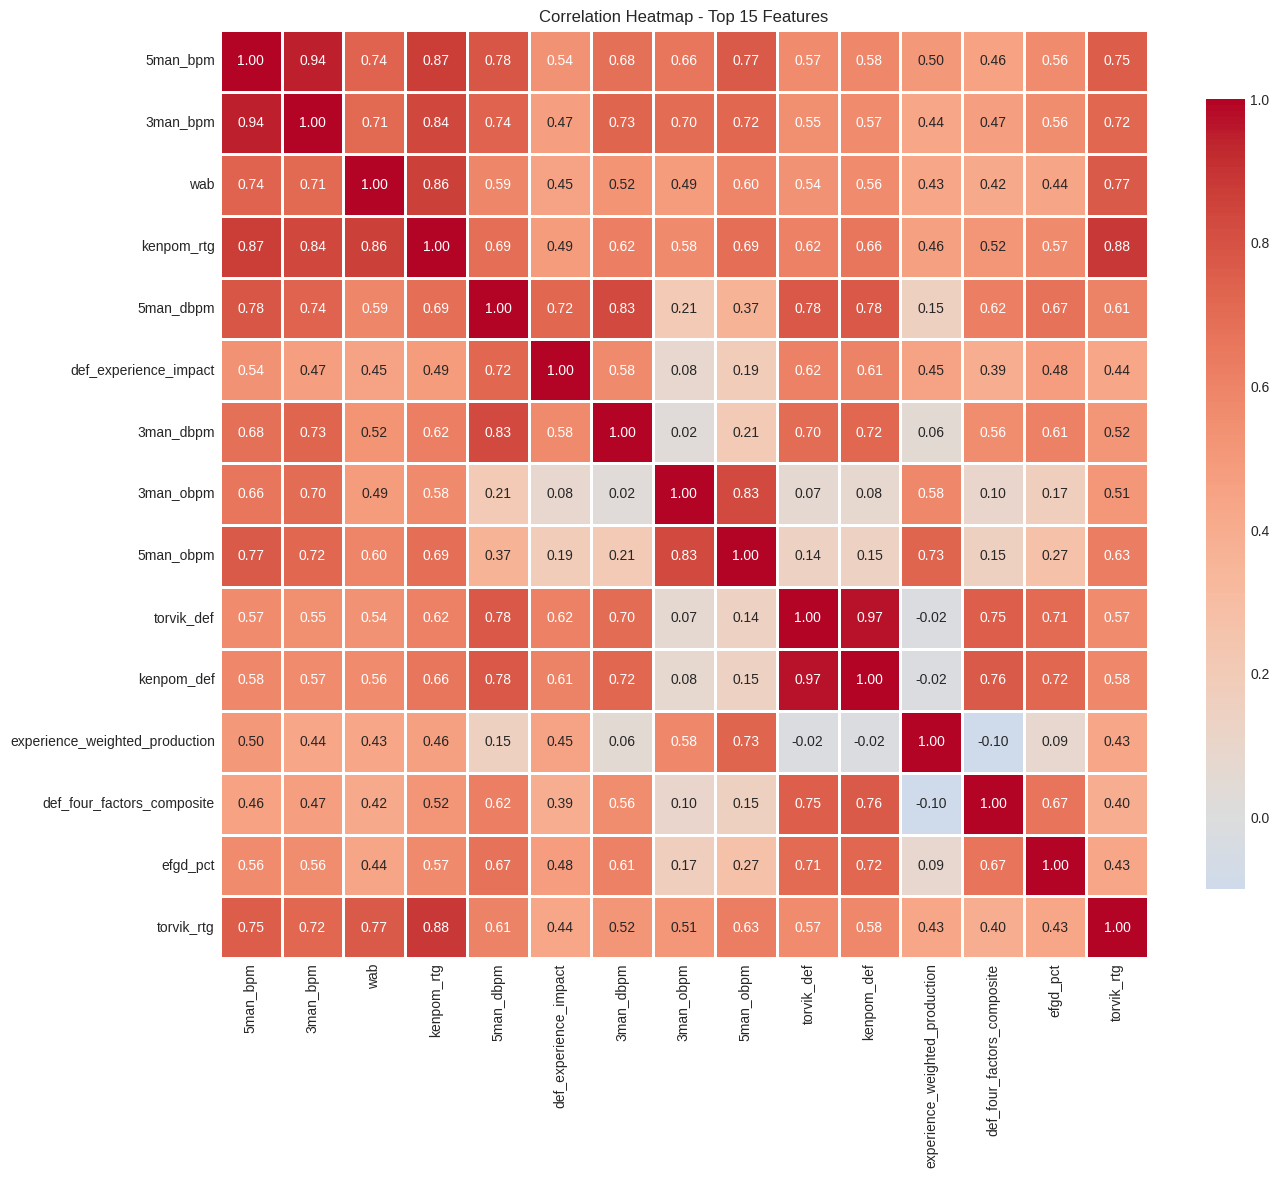

In [15]:
# Plot 2: Feature correlation heatmap (top features)
plt.figure(figsize=(14, 12))
top_features = top_20['Feature'].head(15).tolist()
corr_matrix = X_train[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Top 15 Features')
plt.tight_layout()
plt.show()

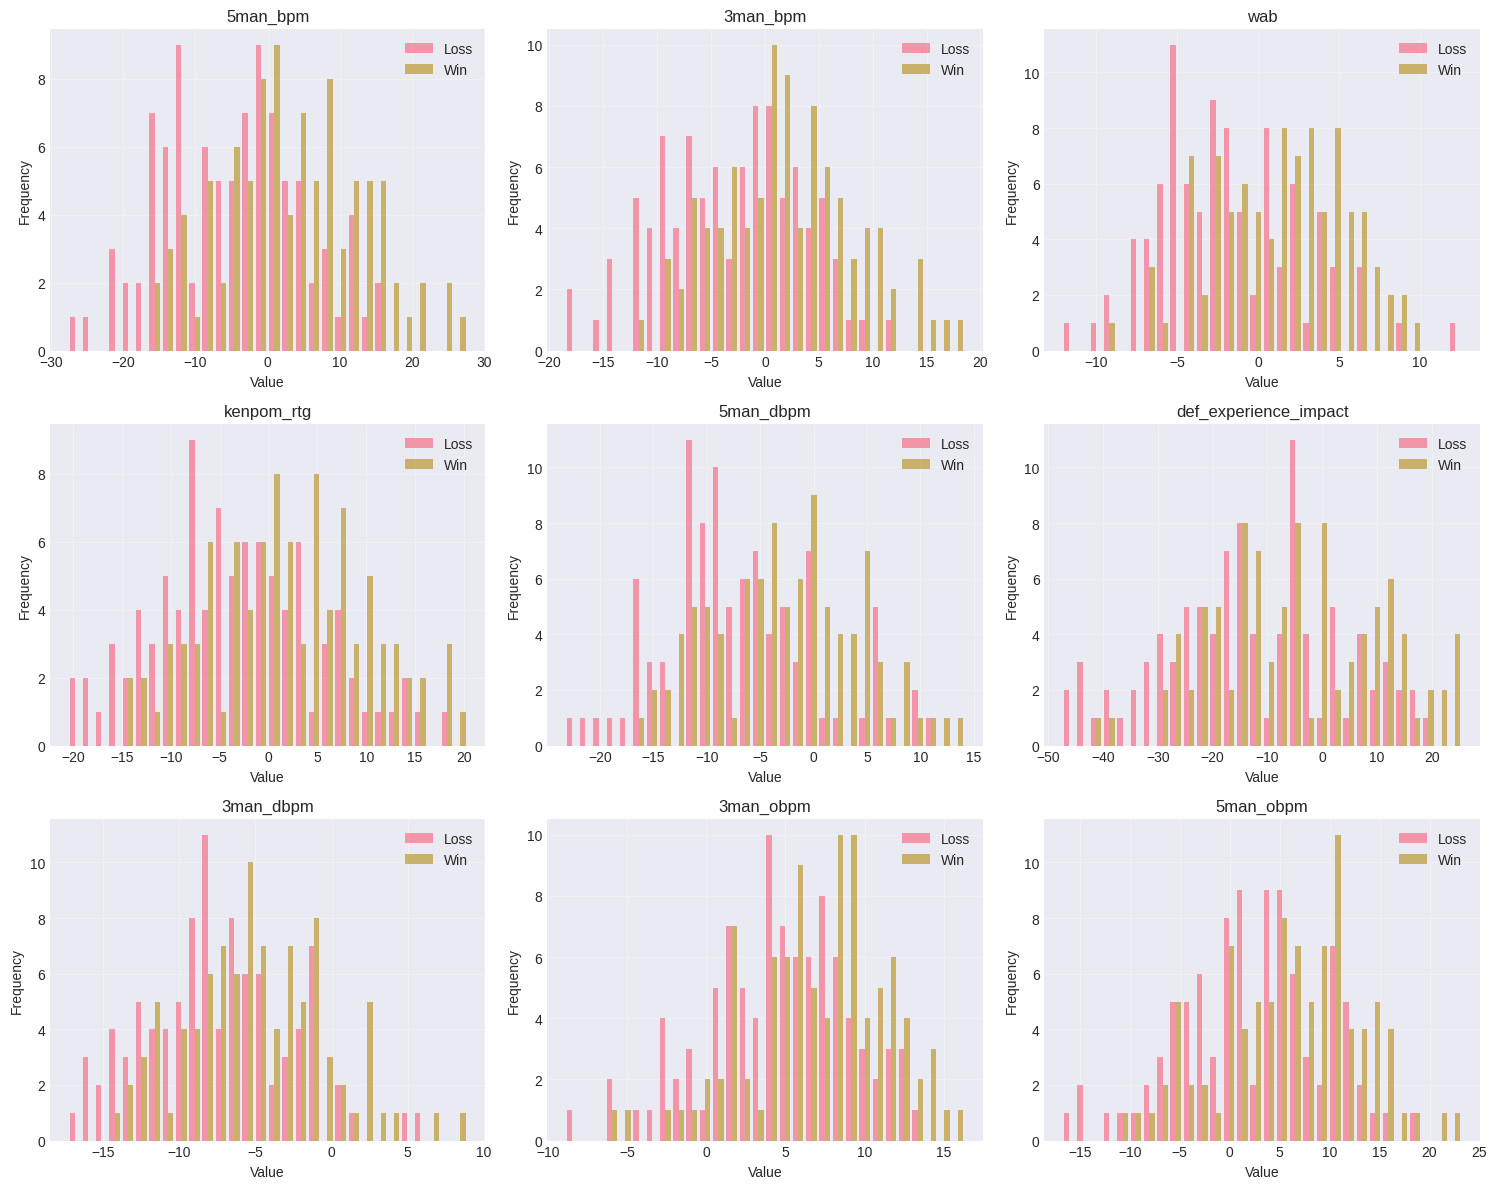

In [16]:
# Plot 3: Feature distributions for top features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feat in enumerate(top_features[:9]):
    axes[idx].hist([X_train[feat][y_train==0], X_train[feat][y_train==1]],
                  bins=30, alpha=0.7, label=['Loss', 'Win'])
    axes[idx].set_title(f'{feat}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:

# Statistical summary
print("\n--- Statistical Summary of Top 10 Features ---")
print(X_train[top_features[:10]].describe().T[['mean', 'std', 'min', 'max']])


--- Statistical Summary of Top 10 Features ---
                            mean        std        min        max
5man_bpm               -0.692632  10.562505 -27.600000  27.600000
3man_bpm               -0.491579   6.918355 -18.500000  18.500000
wab                    -0.251994   4.541787 -12.064713  12.570500
kenpom_rtg             -0.571442   8.711139 -20.503100  20.312980
5man_dbpm              -4.687368   7.325591 -23.200000  14.100000
def_experience_impact  -8.773804  16.325370 -47.318000  25.379942
3man_dbpm              -6.230000   4.904635 -17.300000   8.900000
3man_obpm               5.765263   4.676730  -8.900000  16.300000
5man_obpm               4.124737   7.410222 -16.700000  23.200000
torvik_def            -10.885594   6.590784 -27.500255   6.063415


In [18]:
# ============================================
# 5. FEATURE SELECTION METHODS (ON TRAINING DATA)
# ============================================
print("\n" + "="*60)
print("FEATURE SELECTION METHODS")
print("="*60)

# 5.1 Univariate Feature Selection (ANOVA F-test)
print("\n--- Univariate Feature Selection (ANOVA F-test) ---")
k = 30
selector_uni = SelectKBest(score_func=f_classif, k=k)
selector_uni.fit(X_train, y_train)

univariate_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector_uni.scores_,
    'P_value': selector_uni.pvalues_
}).sort_values('Score', ascending=False)

univariate_features = univariate_scores.head(k)['Feature'].tolist()
print(f"\nTop {k} features selected:")
print(univariate_scores.head(k)[['Feature', 'Score']].to_string(index=False))


FEATURE SELECTION METHODS

--- Univariate Feature Selection (ANOVA F-test) ---

Top 30 features selected:
                       Feature     Score
                      5man_bpm 33.763081
                      3man_bpm 30.352909
                           wab 27.684475
                    kenpom_rtg 20.395874
                     5man_dbpm 18.004936
         def_experience_impact 15.060044
                     3man_dbpm 14.726414
                     3man_obpm 13.908285
                     5man_obpm 13.758659
                    torvik_def 13.213958
                    kenpom_def 11.979079
experience_weighted_production 11.307882
    def_four_factors_composite 10.916197
                      efgd_pct 10.624499
                    torvik_rtg 10.397284
                def_3pt_fg_pct  9.301331
              rotation_balance  9.074778
 def_effective_possession_rate  8.683926
      def_lineup_depth_quality  7.695530
                       3pd_pct  7.287925
                    torvik_off  

In [19]:

# 5.2 Mutual Information Feature Selection
print("\n--- Mutual Information Feature Selection ---")
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
selector_mi.fit(X_train, y_train)

mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

mi_features = mi_scores.head(k)['Feature'].tolist()
print(f"\nTop {k} features selected:")
print(mi_scores.head(k).to_string(index=False))


--- Mutual Information Feature Selection ---

Top 30 features selected:
                       Feature  MI_Score
                           wab  0.126415
                        height  0.122711
              def_close2_share  0.099197
                      3man_bpm  0.092982
               def_dunk_fg_pct  0.083200
               off_dunk_fg_pct  0.078219
                    torvik_def  0.076142
                      5man_bpm  0.071581
         def_experience_impact  0.068357
     def_shot_quality_variance  0.065915
      def_lineup_depth_quality  0.055348
experience_weighted_production  0.054827
                       3pd_pct  0.050580
                     5man_dbpm  0.044748
     effective_possession_rate  0.044306
    def_four_factors_composite  0.041211
                    kenpom_def  0.041073
          def_paint_touch_rate  0.040472
                     5man_prpg  0.039063
                       blk_pct  0.039029
          lineup_depth_quality  0.037481
 def_effective_possession

In [20]:
# 5.3 Random Forest Feature Importance
print("\n--- Random Forest Feature Importance ---")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

rf_top_features = rf_importance.head(30)['Feature'].tolist()
print(f"\nTop 30 features by importance:")
print(rf_importance.head(30).to_string(index=False))


--- Random Forest Feature Importance ---

Top 30 features by importance:
                          Feature  Importance
                              wab    0.027498
                         5man_bpm    0.026911
                         3man_bpm    0.024640
                        5man_dbpm    0.018137
                        3man_obpm    0.017882
                       torvik_def    0.017672
             def_size_speed_index    0.017137
                             size    0.016043
                   def_far2_share    0.015659
                           height    0.015578
def_three_point_volume_efficiency    0.015350
                        3man_dbpm    0.015114
                 rotation_balance    0.015038
                 size_speed_index    0.013964
                       experience    0.013806
                       torvik_off    0.013565
               mid_range_reliance    0.013391
                         efgd_pct    0.013362
                       kenpom_rtg    0.013078
      

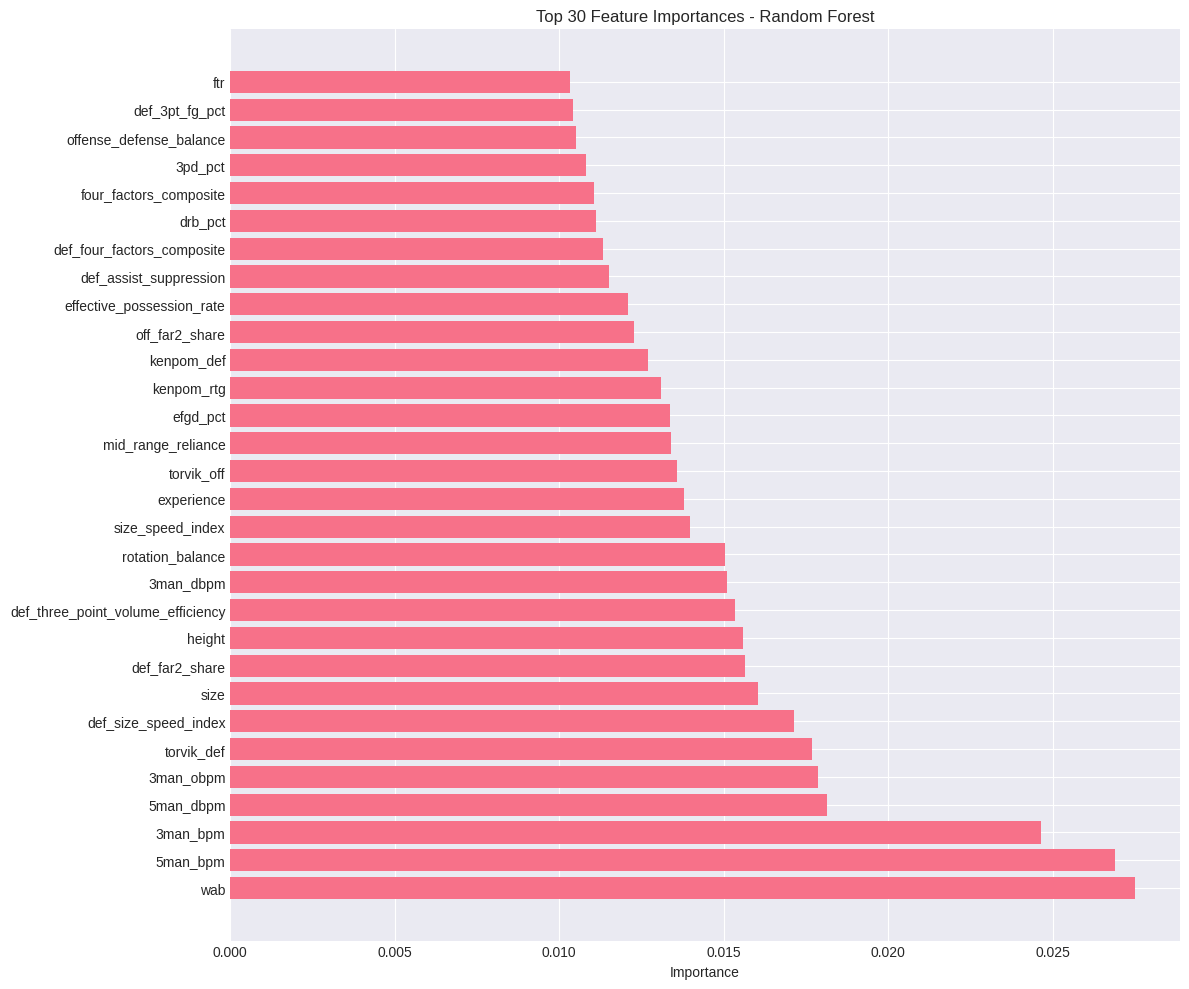

In [21]:
# Plot RF feature importance
plt.figure(figsize=(12, 10))
top_30_rf = rf_importance.head(30)
plt.barh(range(len(top_30_rf)), top_30_rf['Importance'])
plt.yticks(range(len(top_30_rf)), top_30_rf['Feature'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


--- Logistic Regression Feature Importance ---

Top 30 features by importance:
                Feature  Importance
               5man_bpm    0.492856
                    wab    0.195640
       rotation_balance    0.104281
         def_far2_share    0.100757
   def_size_speed_index    0.080792
                   size    0.059802
         def_3pt_fg_pct    0.054421
        off_dunk_fg_pct    0.051878
offense_defense_balance    0.045697
       size_speed_index    0.003000
       def_close2_share    0.002699
              3man_prpg    0.000575
             experience    0.000000
                 height    0.000000
             3man_dprpg    0.000000
                  bench    0.000000
                   3prd    0.000000
         off_dunk_share    0.000000
              adj_tempo    0.000000
              raw_tempo    0.000000
         off_far2_share    0.000000
       off_close2_share    0.000000
         def_dunk_share    0.000000
          off_3pt_share    0.000000
          def_3pt_sh

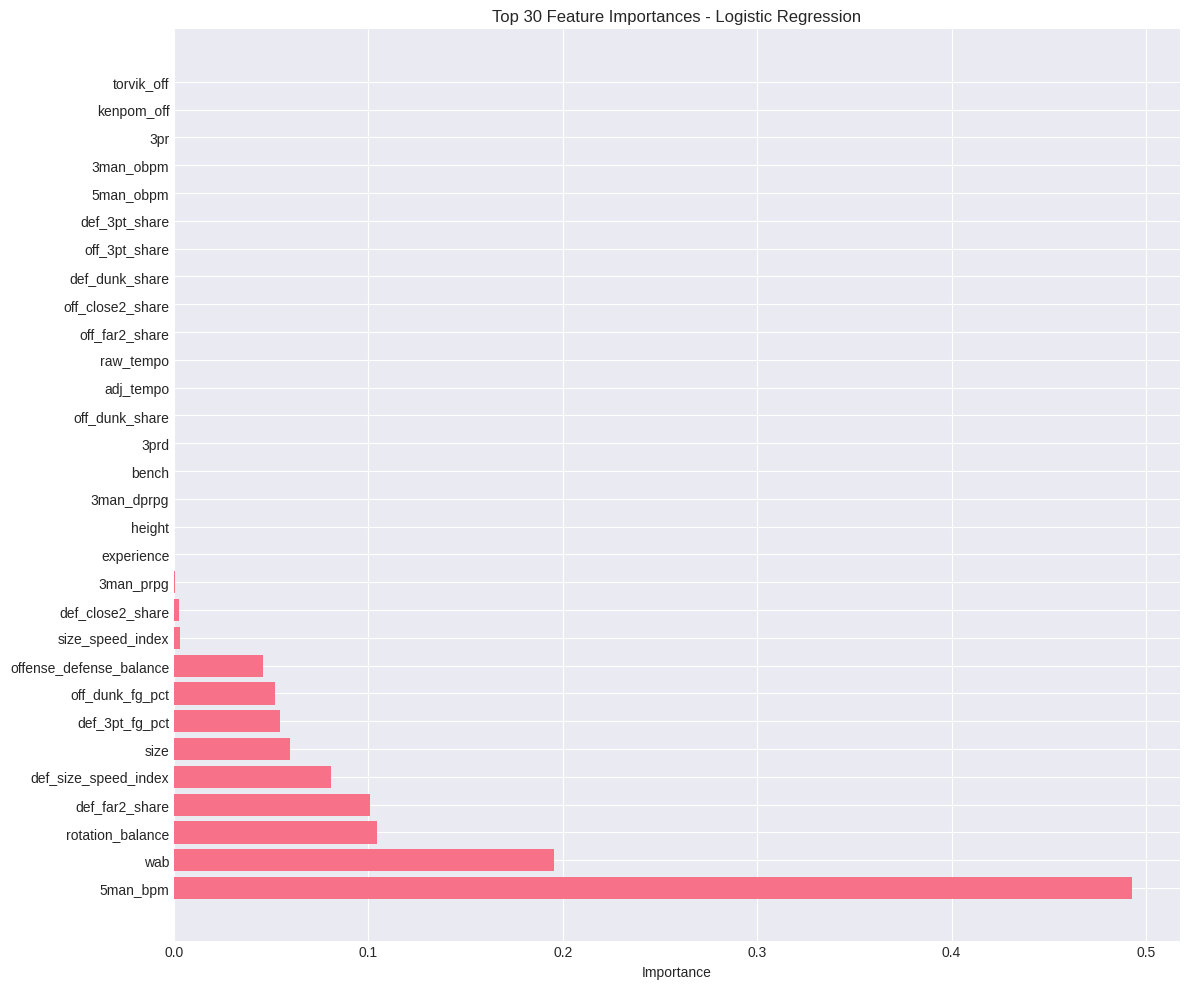

In [22]:
# 5.4 Logistic Regression Feature Importance
print("\n--- Logistic Regression Feature Importance ---")
scaler_temp = StandardScaler()
X_train_scaled_temp = scaler_temp.fit_transform(X_train)

lr_selector = LogisticRegression(max_iter=1000, random_state=42, penalty='l1',
                                 solver='liblinear', C=0.1)
lr_selector.fit(X_train_scaled_temp, y_train)

lr_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(lr_selector.coef_[0])
}).sort_values('Importance', ascending=False)

lr_top_features = lr_importance.head(30)['Feature'].tolist()
print(f"\nTop 30 features by importance:")
print(lr_importance.head(30).to_string(index=False))

# Plot LR feature importance
plt.figure(figsize=(12, 10))
top_30_lr = lr_importance.head(30)
plt.barh(range(len(top_30_lr)), top_30_lr['Importance'])
plt.yticks(range(len(top_30_lr)), top_30_lr['Feature'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances - Logistic Regression')
plt.tight_layout()
plt.show()

In [23]:
# 5.5 Recursive Feature Elimination (RFE)
print("\n--- Recursive Feature Elimination (RFE) ---")
rfe_estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
selector_rfe = RFE(estimator=rfe_estimator, n_features_to_select=30, step=5)
selector_rfe.fit(X_train, y_train)

rfe_rankings = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector_rfe.ranking_,
    'Selected': selector_rfe.support_
}).sort_values('Ranking')

rfe_features = rfe_rankings[rfe_rankings['Selected']]['Feature'].tolist()
print(f"\nTop 30 features selected:")
print(rfe_rankings.head(30)[['Feature', 'Ranking']].to_string(index=False))

# Top correlation features
correlation_features = correlations.nlargest(30, 'Abs_Correlation')['Feature'].tolist()
correlation_features


--- Recursive Feature Elimination (RFE) ---

Top 30 features selected:
                    Feature  Ranking
                   5man_bpm        1
                   3man_bpm        1
                        wab        1
                 kenpom_rtg        1
                 5man_dprpg        1
                  3man_prpg        1
                     height        1
                       size        1
                 experience        1
                        3pr        1
             off_far2_share        1
                 torvik_off        1
                  3man_obpm        1
             def_far2_share        1
                       3prd        1
                 kenpom_def        1
                    drb_pct        1
                  5man_dbpm        1
                 torvik_def        1
offensive_versatility_score        1
           rotation_balance        1
 def_four_factors_composite        1
defensive_versatility_score        1
      def_experience_impact        1
   

['5man_bpm',
 '3man_bpm',
 'wab',
 'kenpom_rtg',
 '5man_dbpm',
 'def_experience_impact',
 '3man_dbpm',
 '3man_obpm',
 '5man_obpm',
 'torvik_def',
 'kenpom_def',
 'experience_weighted_production',
 'def_four_factors_composite',
 'efgd_pct',
 'torvik_rtg',
 'def_3pt_fg_pct',
 'rotation_balance',
 'def_effective_possession_rate',
 'def_lineup_depth_quality',
 '3pd_pct',
 'torvik_off',
 'kenpom_off',
 'four_factors_composite',
 '2pd_pct',
 'lineup_depth_quality',
 'astd_pct',
 'elite_outcome_probability',
 'assist_to_usage_ratio',
 'def_assist_suppression',
 '3man_prpg']

In [24]:
# ============================================
# 6. MODEL COMPARISON WITH DIFFERENT FEATURE SETS
# ============================================
print("\n" + "="*60)
print("MODEL COMPARISON WITH DIFFERENT FEATURE SETS")
print("="*60)

# Define feature sets
feature_sets = {
    'Top_30_Correlation': correlation_features,
    'Univariate_F_Test': univariate_features,
    'Mutual_Information': mi_features,
    'RF_Importance': rf_top_features,
    'LR_Importance': lr_top_features,
    'RFE_Selected': rfe_features,
    'All_Features': X_train.columns.tolist()
}

results_summary = []

for set_name, features in feature_sets.items():
    print(f"\n{'#'*60}")
    print(f"FEATURE SET: {set_name} ({len(features)} features)")
    print(f"{'#'*60}")

    # Prepare data subsets
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Scale for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_subset)
    X_test_scaled = scaler.transform(X_test_subset)

    # === Random Forest ===
    print(f"\n--- Random Forest - {set_name} ---")
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_subset, y_train)

    # RF Predictions
    rf_y_pred = rf_model.predict(X_test_subset)
    rf_y_pred_proba = rf_model.predict_proba(X_test_subset)[:, 1]

    # RF Metrics
    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_cv_scores = cross_val_score(rf_model, X_train_subset, y_train, cv=5, scoring='accuracy')
    rf_cv_mean = rf_cv_scores.mean()
    rf_cv_std = rf_cv_scores.std()

    try:
        rf_auc = roc_auc_score(y_test, rf_y_pred_proba)
    except:
        rf_auc = None

    print(f"Test Accuracy: {rf_accuracy:.4f}")
    print(f"Cross-Validation Accuracy: {rf_cv_mean:.4f} (+/- {rf_cv_std:.4f})")
    if rf_auc:
        print(f"ROC AUC Score: {rf_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_y_pred, target_names=['Loss', 'Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, rf_y_pred))

    # === Logistic Regression ===
    print(f"\n--- Logistic Regression - {set_name} ---")
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        C=1.0,
        penalty='l2'
    )
    lr_model.fit(X_train_scaled, y_train)

    # LR Predictions
    lr_y_pred = lr_model.predict(X_test_scaled)
    lr_y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

    # LR Metrics
    lr_accuracy = accuracy_score(y_test, lr_y_pred)
    lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    lr_cv_mean = lr_cv_scores.mean()
    lr_cv_std = lr_cv_scores.std()

    try:
        lr_auc = roc_auc_score(y_test, lr_y_pred_proba)
    except:
        lr_auc = None

    print(f"Test Accuracy: {lr_accuracy:.4f}")
    print(f"Cross-Validation Accuracy: {lr_cv_mean:.4f} (+/- {lr_cv_std:.4f})")
    if lr_auc:
        print(f"ROC AUC Score: {lr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, lr_y_pred, target_names=['Loss', 'Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, lr_y_pred))

    # Store results
    results_summary.append({
        'Feature_Set': set_name,
        'Num_Features': len(features),
        'RF_Test_Accuracy': rf_accuracy,
        'RF_CV_Mean': rf_cv_mean,
        'RF_CV_Std': rf_cv_std,
        'LR_Test_Accuracy': lr_accuracy,
        'LR_CV_Mean': lr_cv_mean,
        'LR_CV_Std': lr_cv_std
    })


MODEL COMPARISON WITH DIFFERENT FEATURE SETS

############################################################
FEATURE SET: Top_30_Correlation (30 features)
############################################################

--- Random Forest - Top_30_Correlation ---
Test Accuracy: 0.6667
Cross-Validation Accuracy: 0.6211 (+/- 0.0357)
ROC AUC Score: 0.6910

Classification Report:
              precision    recall  f1-score   support

        Loss       0.70      0.58      0.64        24
         Win       0.64      0.75      0.69        24

    accuracy                           0.67        48
   macro avg       0.67      0.67      0.66        48
weighted avg       0.67      0.67      0.66        48


Confusion Matrix:
[[14 10]
 [ 6 18]]

--- Logistic Regression - Top_30_Correlation ---
Test Accuracy: 0.6667
Cross-Validation Accuracy: 0.6789 (+/- 0.0632)
ROC AUC Score: 0.7465

Classification Report:
              precision    recall  f1-score   support

        Loss       0.68      0.62      0.